In [2]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from dtaidistance import dtw
import librosa

In [3]:
sample_rate1, sig1 = wav.read('voice_pratham.wav')  # my voice
sample_rate2, sig2 = wav.read('voice_shivam.wav')  # Shivam's voice

In [4]:
if len(sig1.shape) > 1:
    sig1 = sig1[:,0]
if len(sig2.shape) > 1:
    sig2 = sig2[:,0]

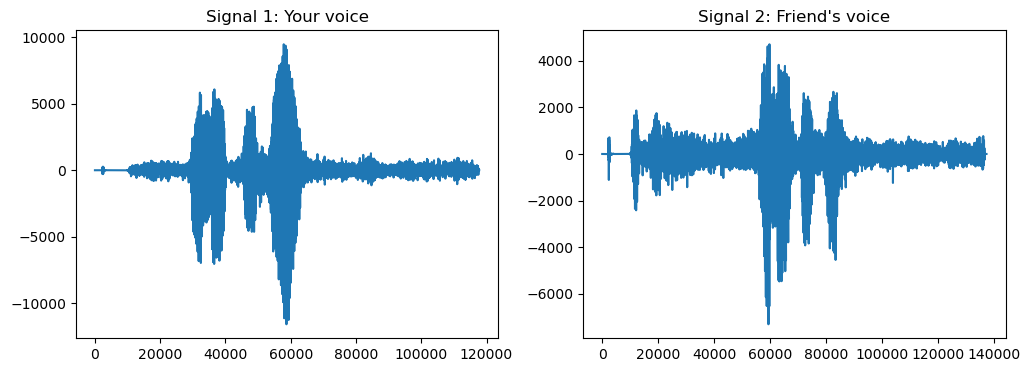

In [5]:
# 3. Visualization: Plot raw signals
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(sig1)
plt.title('Signal 1: Your voice')
plt.subplot(1,2,2)
plt.plot(sig2)
plt.title("Signal 2: Friend's voice")
plt.show()

### Normalize both signals so they have comparable amplitude ranges.

In [6]:
sig1_norm = sig1 / np.max(np.abs(sig1))
sig2_norm = sig2 / np.max(np.abs(sig2))

In [7]:
# Trim first 1 second of audio
sig1_trim = sig1_norm[:sample_rate1]
sig2_trim = sig2_norm[:sample_rate2]

# Downsample strongly to avoid memory issues
factor = 50
sig1_small = sig1_trim[::factor]
sig2_small = sig2_trim[::factor]

print("Reduced Signal 1 length:", len(sig1_small))
print("Reduced Signal 2 length:", len(sig2_small))


Reduced Signal 1 length: 960
Reduced Signal 2 length: 960


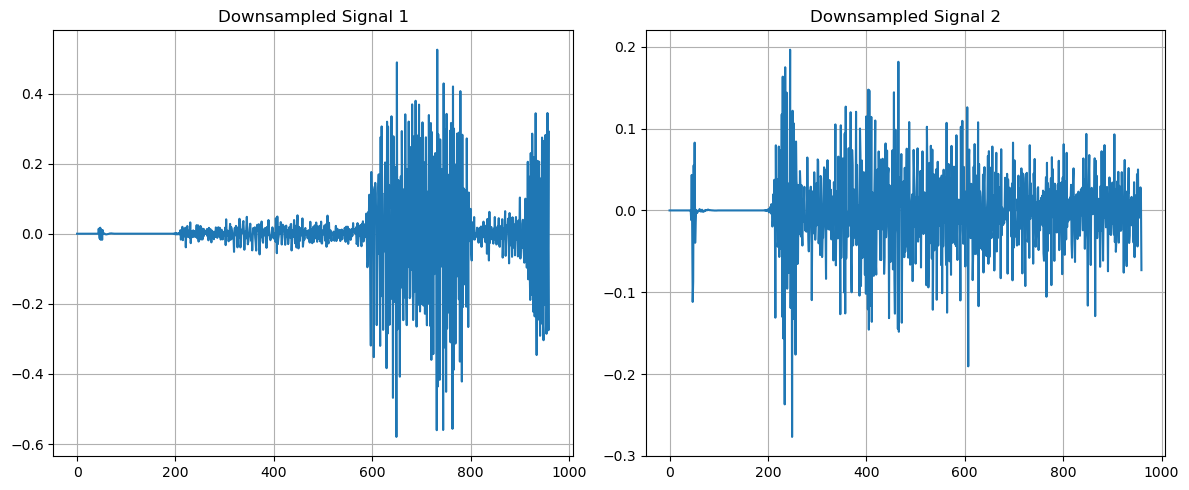

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(sig1_small)
plt.title("Downsampled Signal 1")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(sig2_small)
plt.title("Downsampled Signal 2")
plt.grid(True)

plt.tight_layout()
plt.show()

### Apply Dynamic Time Warping on the two signals.

In [9]:
def dtw(x, y):
    n = len(x)
    m = len(y)

    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(x[i-1] - y[j-1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],     # insertion
                dtw_matrix[i, j-1],     # deletion
                dtw_matrix[i-1, j-1]    # match
            )
    return dtw_matrix

In [10]:
dtw_matrix = dtw(sig1_small, sig2_small)
dtw_matrix

array([[ 0.        ,         inf,         inf, ...,         inf,
                inf,         inf],
       [        inf,  0.        ,  0.        , ..., 31.52686261,
        31.54080656, 31.61380725],
       [        inf,  0.        ,  0.        , ..., 31.52686261,
        31.54080656, 31.61380725],
       ...,
       [        inf, 55.98565875, 55.98565875, ..., 53.28732912,
        53.34032275, 53.37427376],
       [        inf, 56.26099352, 56.26099352, ..., 53.52361422,
        53.57660785, 53.54265684],
       [        inf, 56.55179266, 56.55179266, ..., 53.71904105,
        53.8004694 , 53.90645666]], shape=(961, 961))

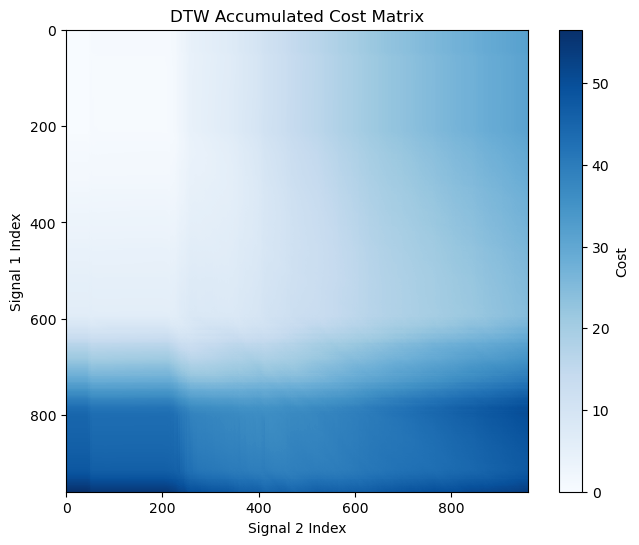

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(dtw_matrix[1:,1:], cmap='Blues', interpolation='nearest')
plt.title("DTW Accumulated Cost Matrix")
plt.xlabel("Signal 2 Index")
plt.ylabel("Signal 1 Index")
plt.colorbar(label="Cost")
plt.show()

### Produce the alignment path and compute the total DTW distance.

In [12]:
def extract_path(dtw_matrix):
    i, j = np.array(dtw_matrix.shape) - 1
    path = [(i-1, j-1)]

    while i > 1 or j > 1:
        options = [
            (i-1, j-1),
            (i-1, j),
            (i, j-1)
        ]
        costs = [dtw_matrix[o] for o in options]
        idx = np.argmin(costs)
        i, j = options[idx]
        path.append((i-1, j-1))

    path.reverse()
    return path

path = extract_path(dtw_matrix)

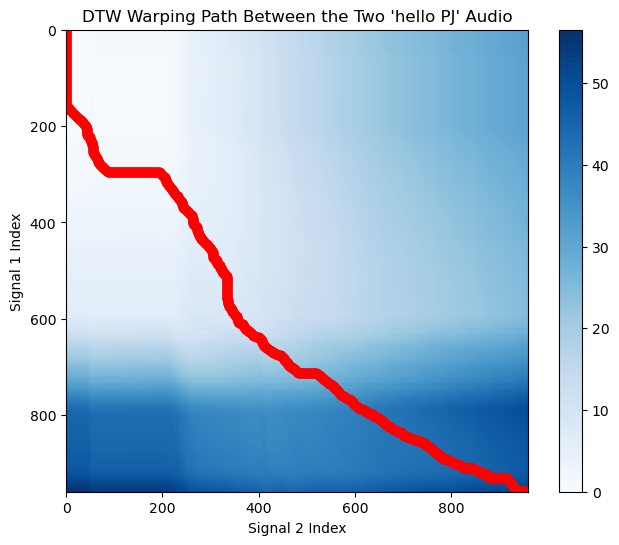

In [13]:
px, py = zip(*path)

plt.figure(figsize=(8,6))
plt.imshow(dtw_matrix[1:,1:], cmap='Blues', interpolation='nearest')
plt.plot(py, px, '-o', color='red')
plt.title("DTW Warping Path Between the Two 'hello PJ' Audio")
plt.xlabel("Signal 2 Index")
plt.ylabel("Signal 1 Index")
plt.colorbar()
plt.show()

In [14]:
dtw_distance = dtw_matrix[-1, -1]
print("DTW Distance between my 'hello PJ' and friend's 'hello PJ':", dtw_distance)

DTW Distance between my 'hello PJ' and friend's 'hello PJ': 53.90645665804008
